In [36]:
import random
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model
from preprocessing.generator import preprocess_test

IMG_WIDTH = IMG_HEIGHT = 256
IMG_CHANNELS = 3


In [37]:
model = load_model('./snapshots/keras_unet.h5')

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [39]:
test_X, _, _ = preprocess_test(input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

100%|██████████| 65/65 [00:02<00:00, 30.30it/s]


In [40]:
predictions = model.predict(test_X)

In [41]:
predictions = np.squeeze(predictions)

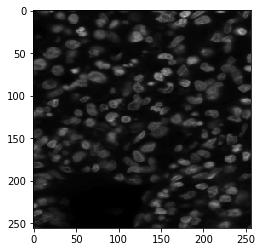

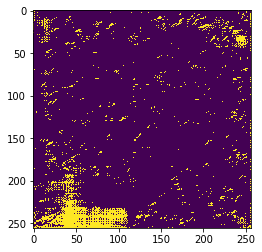

In [49]:
index_ = random.randint(0, len(test_X))

plt.imshow(test_X[index_])
plt.show()

plt.imshow(predictions[index_] > 0.3)
plt.show()